# Imports

In [1]:
import mne
import numpy as np
import pandas as pd
import math
import itertools
import matplotlib.pyplot as plt
from dtaidistance import dtw_visualisation as dtwvis
from dtw import *
from scipy.interpolate import CubicSpline
from scipy.signal import resample
from scipy.signal import butter
from scipy.signal import filtfilt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper
import seaborn as sns
import os
import glob
import re

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Legacy Functions

In [4]:
def dtw_align_gait_signals(file_path):
    #Original Tiwe-Warping function obtained from Lea Chabrowsky
    #Input: file_path to the gaitalytics file of interest
    #Output: all_signals_aligned_by_dtw = time-warped signals, ratio_max_min_dtw_distance = distance ratio bewteen time-warped and reference signals
    df = pd.read_csv(file_path)
    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)

    df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
    min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)

    subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
    subset_signal = subset_signal.reset_index(drop=True)

    subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
    mean_per_column = subset_signal_only_float_values.mean(axis=0)
    mean_per_column = mean_per_column[~np.isnan(mean_per_column)]
    reference_signal = resample(mean_per_column, min_length)

    b, a = butter(2, 3, fs=100, btype='low')
    reference_signal_filt = filtfilt(b, a, reference_signal)
    reference_signal_filt = reference_signal_filt.astype(float)

    all_signals_aligned_by_dtw = pd.DataFrame()
    min_distance_dtw = float('inf')
    max_distance_dtw = 0
    for i in range(len(subset_signal_only_float_values)):

        gait_cycle_1 = subset_signal_only_float_values.iloc[i][:].values
        nan_mask = np.isnan(gait_cycle_1)
        gait_cycle_1 = gait_cycle_1[~nan_mask]
        y = filtfilt(b, a, gait_cycle_1)
        float_array_gait_cycle = y.astype(float)

        alignment2 = dtw(float_array_gait_cycle, reference_signal_filt, keep_internals=True,
                         step_pattern=rabinerJuangStepPattern(3, "c"))

        if alignment2.distance < min_distance_dtw:
            min_distance_dtw = alignment2.distance

        if alignment2.distance > max_distance_dtw:
            max_distance_dtw = alignment2.distance

        id_reference2 = alignment2.index2
        id_query2 = alignment2.index1
        cs2 = CubicSpline(id_reference2, gait_cycle_1[id_query2])
        xs = np.arange(min_length)
        signal_aligned_by_dtw = resample(cs2(xs), 100)
        signal_aligned_by_dtw_df = pd.DataFrame(signal_aligned_by_dtw)
        signal_aligned_by_dtw_df = signal_aligned_by_dtw_df.transpose()
        all_signals_aligned_by_dtw = pd.concat([all_signals_aligned_by_dtw, signal_aligned_by_dtw_df], axis = 0)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.reset_index(drop=True)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.astype(float)

    ratio_max_min_dtw_distance = max_distance_dtw/min_distance_dtw
    return all_signals_aligned_by_dtw, ratio_max_min_dtw_distance





#This function aligns gait cycle data using dynamic time warping by considering that the
#reference signal is the normalized and filtered mean signal.
#The output of this function is a plot of the normalized and aligned gait cycles
#For this function to work properly the structure of the dataset should be composed of 3 columns:
#'cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'.
def plot_dtw_align_gait_signals(file_path,reference_id=None,EEG=None,ICA=None):
    fig, axs = plt.subplots(2)
    
    df = pd.read_csv(file_path)

    if EEG is not None:
        times = EEG.times
        df = df[df['end_frame']<times[-1]*100]
        eeg_data = EEG.get_data()
        eeg_times = EEG.times
        

    signal_length = np.zeros((len(df),3))
    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)

    df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
    min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    max_length = np.max(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
    subset_signal = subset_signal.reset_index(drop=True)

    subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
    mean_per_column = subset_signal_only_float_values.mean(axis=0)
    mean_per_column = mean_per_column[~np.isnan(mean_per_column)]
    reference_signal = resample(mean_per_column, min_length)
    
    
    if reference_id is not None:
        reference_signal = subset_signal_only_float_values.iloc[reference_id]
        reference_signal = reference_signal[~np.isnan(reference_signal)]
        reference_signal = upsample(reference_signal,100,500)
        #reference_signal = resample(reference_signal, min_length)
        
    b, a = butter(2, 6, fs=100, btype='low')
    reference_signal_filt = filtfilt(b, a, reference_signal)
    reference_signal_filt = reference_signal_filt.astype(float)

    all_signals_aligned_by_dtw = pd.DataFrame()
    min_distance_dtw = float('inf')
    max_distance_dtw = 0
    plt.figure(figsize=(10, 6))

    if EEG is not None:
        eeg_set = np.zeros((len(df),eeg_data.shape[0],min_length*5))
        print(eeg_set.shape)
        time_lapses = np.zeros((len(df),2))

    for i in range(len(subset_signal_only_float_values)):

        gait_cycle_1 = subset_signal_only_float_values.iloc[i][:].values
        nan_mask = np.isnan(gait_cycle_1)
        gait_cycle_1 = gait_cycle_1[~nan_mask]
        gait_cycle_1 = upsample(gait_cycle_1,100,500)
        y = filtfilt(b, a, gait_cycle_1)
        float_array_gait_cycle = y.astype(float)

        alignment2 = dtw(float_array_gait_cycle, reference_signal_filt, keep_internals=True,
                         step_pattern=rabinerJuangStepPattern(3, "c"))

        if alignment2.distance < min_distance_dtw:
            min_distance_dtw = alignment2.distance

        if alignment2.distance > max_distance_dtw:
            max_distance_dtw = alignment2.distance

        id_reference2 = alignment2.index2
        id_query2 = alignment2.index1
        cs2 = CubicSpline(id_reference2, gait_cycle_1[id_query2])
        

        xs = np.arange(min_length*5)
        xs2 = np.arange(0,len(id_query2))
        signal_aligned_by_dtw = cs2(xs)
        signal_aligned_by_dtw2 = cs2(xs2)

        if EEG is not None:
            time_lapse = [df.iloc[i]['start_frame']/100,df.iloc[i]['end_frame']/100]
            time_lapses[i,:] = time_lapse
            eeg_mask = (eeg_times<time_lapse[1])&(eeg_times>time_lapse[0])
            eeg_data_sel = eeg_data[:,eeg_mask]
            eeg_query = id_query2[id_query2<eeg_data_sel.shape[1]]
            eeg_reference = id_reference2[:len(eeg_query)]
            es2 = CubicSpline(eeg_reference, eeg_data_sel[:,eeg_query],axis=1)
            eeg_aligned_by_dtw = es2(xs)
            eeg_set[i,:] = eeg_aligned_by_dtw

        signal_aligned_by_dtw_df = pd.DataFrame(signal_aligned_by_dtw)
        signal_aligned_by_dtw_df = signal_aligned_by_dtw_df.transpose()
        all_signals_aligned_by_dtw = pd.concat([all_signals_aligned_by_dtw, signal_aligned_by_dtw_df], axis = 0)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.reset_index(drop=True)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.astype(float)

        axs[0].plot(np.linspace(0, 100, len(xs)),signal_aligned_by_dtw)
        axs[1].plot(np.linspace(0, 100, len(xs2)),signal_aligned_by_dtw2)
        signal_length[i,0] = len(gait_cycle_1)
        signal_length[i,1] = len(signal_aligned_by_dtw)
        signal_length[i,2] = len(signal_aligned_by_dtw2)

    plt.title('All signals aligned by dtw and normalized')
    plt.legend()
    if EEG is not None:
        return signal_length,eeg_set,time_lapses
    
    return signal_length

def upsample(signal,low_freq,high_freq):
    n_samples = len(signal)
    signal_up = resample(signal,int(n_samples*(high_freq/low_freq)))
    return signal_up

def align_motion(file_path,EEG,epochs_resampled):
    df = pd.read_csv(file_path)
    plt.figure(figsize=(10, 6))
    times = EEG.times
    df = df[df['end_frame']<times[-1]*100]
    eeg_data = EEG.get_data()
    eeg_times = EEG.times

    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)

    df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
    min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    max_length = np.max(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
    subset_signal = subset_signal.reset_index(drop=True)

    subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
    mean_per_column = subset_signal_only_float_values.mean(axis=0)
    mean_per_column = mean_per_column[~np.isnan(mean_per_column)]
    reference_signal = resample(mean_per_column, min_length)
    
    epoch_length = epochs_resampled.shape[2]
    for i in range(len(subset_signal_only_float_values)):
        signal = subset_signal_only_float_values.iloc[i]
        signal = signal[~np.isnan(signal)]
        signal = resample(signal,epoch_length)
        #reference_signal = resample(reference_signal, min_length)
        plt.plot(signal)
    plt.show()
    '''    
    b, a = butter(2, 6, fs=100, btype='low')
    reference_signal_filt = filtfilt(b, a, reference_signal)
    reference_signal_filt = reference_signal_filt.astype(float)

    all_signals_aligned_by_dtw = pd.DataFrame()
    min_distance_dtw = float('inf')
    max_distance_dtw = 0
    '''
    return

# Functions

In [8]:
def align_eeg(file_path,EEG,ICA,plot_align=False):
    events_from_annot, event_dict = mne.events_from_annotations(EEG)
    offset_id = events_from_annot[events_from_annot[:,2]==event_dict['s1']][0][0]
    df = pd.read_csv(file_path)
    times = EEG.times
    offset = times[offset_id]
    #times = times - offset EEG should already be aligned
    df = df[df['end_frame']<times[-1]*100]
    eeg_data = EEG.get_data()

    epochs = []
    epochs_ica = []
    max_samples = 0

    for i in range(df.shape[0]):
        t_start = df.iloc[i]['start_frame']/100
        t_end = df.iloc[i]['end_frame']/100
        time_mask = (times>t_start)&(times<t_end)
        eeg_section = eeg_data[:,time_mask]
        #ica_section = ICA[:,time_mask]

        if eeg_section.shape[1] > max_samples:
            max_samples = eeg_section.shape[1]

        epochs.append(eeg_section)
        #epochs_ica.append(ica_section)

    epochs_resampled = np.zeros((df.shape[0],eeg_data.shape[0],max_samples))
    #epochs_ica_resampled = np.zeros((df.shape[0],ICA.shape[0],max_samples))


    for i in range(len(epochs)):
        epoch_resampled = resample(epochs[i],max_samples,axis=1)
        #epoch_ica_resampled = resample(epochs_ica[i],max_samples,axis=1)
        epochs_resampled[i,:] = epoch_resampled
        #epochs_ica_resampled[i,:] = epoch_ica_resampled
    epochs_ica_resampled = []

    return epochs,epochs_resampled,epochs_ica_resampled

def reconstruct_eeg(raw,epochs_set):
    reconstructed_eeg_data = np.zeros((epochs_set.shape[1],epochs_set.shape[2]*epochs_set.shape[0]))
    
    t_stamps = []
    target_nb = []
    for i in range(epochs_set.shape[0]):
        low_idx = i*epochs_set.shape[2]
        high_idx = (i+1)*epochs_set.shape[2]
        reconstructed_eeg_data[:,low_idx:high_idx] = epochs_set[i]

        t_stamps = t_stamps + [i+0,i+0.1,i+.5,i+0.6]
        target_nb = target_nb+['LHS','RTO','RHS','LTO']

    annots = mne.Annotations(onset=t_stamps, duration = 0., description=target_nb);
    info = mne.create_info(raw.info['ch_names'],epochs_set[0,:].shape[1],ch_types='eeg')
    reconstructed_eeg = mne.io.RawArray(reconstructed_eeg_data,info)
    reconstructed_eeg = reconstructed_eeg.copy().set_annotations(annots);

    return reconstructed_eeg

def annotate_eeg(EEG,file_path):
    
    events_from_annot, event_dict = mne.events_from_annotations(EEG)
    offset_id = events_from_annot[events_from_annot[:,2]==event_dict['s1']][0][0]
    df = pd.read_csv(file_path)
    times = EEG.times
    offset = times[offset_id]
    times = times - offset
    df = df[df['end_frame']<times[-1]*100]
    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)
    t_stamps = []
    for i in range(df.shape[0]):
        t_stamps.append(df.iloc[i]['start_frame']/100 + offset)
    target_nb = ['LHS']*(len(t_stamps))
    annots = mne.Annotations(onset=t_stamps, duration = 0., description=target_nb);
    raw_annotated = EEG.copy().set_annotations(annots);
    return raw_annotated

def epoch_from_annotations(eeg_annotated,tmin=0,tmax=1,baseline=None,ch_picks=['C3','C4','Cz']):
    events_from_annot, event_dict = mne.events_from_annotations(eeg_annotated)
    epochs = mne.Epochs(eeg_annotated, events_from_annot, event_dict, tmin = tmin-0.1, tmax = tmax+0.1, baseline=baseline,picks=ch_picks)
    return epochs

def get_epoch(eeg,t_min=0,t_max=1,baseline=None,preload=False,event_marker='LHS'):
    eventss, event_idss = mne.events_from_annotations(eeg);
    event_ids = {key: event_idss[key] for key in [event_marker]}
    epochs = mne.Epochs(eeg, eventss, event_id=event_ids, tmin = t_min-0.1, tmax = t_max+0.1, baseline=baseline,preload=preload)
    return epochs

def get_epoch2(eeg,tmin=0,tmax=1,baseline=None,event_marker='LHS'):
    eventss, event_idss = mne.events_from_annotations(eeg);
    event_ids = {key: event_idss[key] for key in [event_marker]}
    event = eventss[eventss[:,2]==event_idss[event_marker]]
    epochs = mne.Epochs(eeg,event, tmin = tmin-0.1, tmax = tmax+0.1, baseline=baseline)
    return epochs

def time_warp_signal(target_signal,file_path,max_length,reference_id=None):
    # Here we assume that signal first dim = gait cycles and last dim = time points
    
    fig, axs = plt.subplots(2)
    length_target_signal = target_signal.shape[-1]
    df = pd.read_csv(file_path) 

    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)

    df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
    min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    max_length = np.max(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
    subset_signal = subset_signal.reset_index(drop=True)

    subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
    
    
    
    if reference_id is not None:
        reference_signal = subset_signal_only_float_values.iloc[reference_id]
        reference_signal = reference_signal[~np.isnan(reference_signal)]
        #reference_signal = upsample(reference_signal,100,500)
        reference_signal = resample(reference_signal, length_target_signal)
    else:
        median_per_column = subset_signal_only_float_values.median(axis=0)
        median_per_column = median_per_column[~np.isnan(median_per_column)]
        reference_signal = resample(median_per_column, min_length)

    b, a = butter(2, 6, fs=100, btype='low')
    reference_signal_filt = filtfilt(b, a, reference_signal)
    reference_signal_filt = reference_signal_filt.astype(float)

    all_signals_aligned_by_dtw = pd.DataFrame()
    min_distance_dtw = float('inf')
    max_distance_dtw = 0

    new_set = np.zeros(target_signal.shape)

    for i in range(len(subset_signal_only_float_values)):

        gait_cycle_1 = subset_signal_only_float_values.iloc[i][:].values
        nan_mask = np.isnan(gait_cycle_1)
        gait_cycle_1 = gait_cycle_1[~nan_mask]
        gait_cycle_1 = resample(gait_cycle_1,length_target_signal)
        y = filtfilt(b, a, gait_cycle_1)
        float_array_gait_cycle = y.astype(float)

        alignment2 = dtw(float_array_gait_cycle, reference_signal_filt, keep_internals=True,
                         step_pattern=rabinerJuangStepPattern(3, "c"))

        if alignment2.distance < min_distance_dtw:
            min_distance_dtw = alignment2.distance

        if alignment2.distance > max_distance_dtw:
            max_distance_dtw = alignment2.distance

        id_reference2 = alignment2.index2
        id_query2 = alignment2.index1
        cs2 = CubicSpline(id_reference2, gait_cycle_1[id_query2])
        

        xs = np.arange(length_target_signal)
        xs2 = np.arange(0,len(id_query2))
        signal_aligned_by_dtw = cs2(xs)
        signal_aligned_by_dtw2 = cs2(xs2)
        
        sub_target_signal = target_signal[i]
        ts2 = CubicSpline(id_reference2, sub_target_signal[...,id_query2],axis=-1)
        target_signal_aligned = ts2(xs)
        new_set[i,:] = target_signal_aligned
        signal_aligned_by_dtw_df = pd.DataFrame(signal_aligned_by_dtw)
        signal_aligned_by_dtw_df = signal_aligned_by_dtw_df.transpose()
        all_signals_aligned_by_dtw = pd.concat([all_signals_aligned_by_dtw, signal_aligned_by_dtw_df], axis = 0)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.reset_index(drop=True)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.astype(float)

        axs[0].plot(np.linspace(0, 100, len(xs)),signal_aligned_by_dtw)
        #axs[1].plot(np.linspace(0, 100, len(xs)),target_signal_aligned)

    plt.title('All signals aligned by dtw and normalized')
    plt.legend()
    plt.show()

    
    return new_set

def get_recording_path(subject_id,condition,root_path='C:/Users/haiou/Documents/Cereneo/Data/Study/5_single-subject-EEG-analysis',file_identifier='cleaned'):
    base_filename = os.path.join(root_path,'sub-'+str(subject_id))
    os.chdir(base_filename)
    for file in glob.glob("*.set"):
        if file_identifier in file:
            subject_path = os.path.join(base_filename, file)

    return subject_path

def get_analysis_path(subject_id,condition,root_path='C:/Users/haiou/Documents/Cereneo/Data/gaitalytics_data'):
    base_filename = os.path.join(root_path,'S'+str(subject_id),'S'+str(subject_id)+'_'+condition)
    os.chdir(base_filename)
    file_identifiers = ['angles','spatio_temp']
    
    for file in glob.glob("*.csv"):
        if file_identifiers[0] in file:
            file_path_angles = os.path.join(base_filename, file)
        elif file_identifiers[1] in file:
            file_path_spatio_temp = os.path.join(base_filename, file)

    return file_path_angles,file_path_spatio_temp

def get_parameter_path(subject_id,condition,marker='knee',parameter='angles',side='left',coordinate='y',nomalisation='Left-normalised',root_path=r'C:\Users\haiou\Documents\Cereneo\Data\Study\gaitalytics'):
    #get_parameter_path(5,'FB','knee','angles','left','y','Left-normalised')
    base_filename = os.path.join(root_path,'S'+str(subject_id),'S'+str(subject_id)+'_'+condition)
    os.chdir(base_filename)
    directory = glob.glob("*.csv")
    file = [i for i in directory if marker in i and parameter in i and side in i and coordinate in i and nomalisation in i]
    
    return os.path.join(base_filename,file[0])

def get_ROI(EEG,roi=['C','P']):
    channels = []
    for i in range(len(roi)):
        channels = channels + [x for x in EEG.ch_names if x[0:len(roi[i])] == roi[i]]
    return channels

def get_epoched_tfr(EEG,file_path,tfr,resampling=False):
    
    events_from_annot, event_dict = mne.events_from_annotations(EEG)
    offset_id = events_from_annot[events_from_annot[:,2]==event_dict['s1']][0][0]
    df = pd.read_csv(file_path)
    times = EEG.times
    offset = times[offset_id]
    times = times - offset
    #df = df[df['end_frame']<times[-1]*100]
    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)
    min_length = 10000
    max_length = 0
    min_id = 0
    max_id = 0
    '''
        for i in range(df.shape[0]):
            t_start = df.iloc[i]['start_frame']/100
            t_end = df.iloc[i]['end_frame']/100
            mask = (times>t_start)&(times<t_end)
            length = sum(mask)
            if length>max_length:
                max_length = length
                max_id = i
    '''

    #epoched_tfr = np.zeros((df.shape[0],)+tfr.shape[0:-1]+(max_length,))
    epoched_tfr = []
    for i in range(df.shape[0]):
        t_start = df.iloc[i]['start_frame']/100 + offset
        t_end = df.iloc[i]['end_frame']/100 + offset
        mask = (times>t_start)&(times<t_end)
        length = sum(mask)
        if length<min_length:
            min_length = length
            min_id = i
        if length>max_length:
                max_length = length
                max_id = i
 
        tfr_mask = tfr[...,mask]
        epoched_tfr.append(tfr_mask)

    if resampling:
        for j in range(len(epoched_tfr)):
            epoched_tfr[j] = resample(epoched_tfr[j],max_length,axis=-1)
        epoched_tfr = np.asarray(epoched_tfr)
    return epoched_tfr,min_length,min_id

def tfr_baselining(baseline_tfr,erds_tfr):
    mean_power = np.squeeze(np.mean(baseline_tfr,axis=-1))
    mean_reshaped = mean_power.reshape((1,)+mean_power.shape+(1,))
    baselined_tfr = erds_tfr.copy()
    baselined_tfr.data = (erds_tfr-mean_reshaped)/mean_reshaped
    return baselined_tfr

def events_for_eeglab(file_path,subject_id,condition,base_filename=r'C:\Users\haiou\Documents\Cereneo\Data\Study\2_raw-EEGLAB'):
    df = pd.read_csv(file_path)
    os.chdir(os.path.join(base_filename,'sub-'+str(subject_id),'D_flow_data'))
    directory = glob.glob("*.txt")
    metadata_recording_file = [i for i in directory if condition in i and 'recording' in i][0]
    metadata_info_file = [i for i in directory if condition in i and 'info' in i][0]
    metadata_recording_path = os.path.join(base_filename,'sub-'+str(subject_id),'D_Flow_data',metadata_recording_file)
    metadata_info_path = os.path.join(base_filename,'sub-'+str(subject_id),'D_Flow_data',metadata_info_file)
    metadata_recording = pd.read_csv(metadata_recording_path,delimiter='\t')
    metadata_info = pd.read_csv(metadata_info_path,delimiter='\t')

    #df = df[df['end_frame']<times[-1]*10]
    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)
    types = []
    latencies = []

    #For noFB event labeling
    if condition == 'noFB':
        ramp_idxs = metadata_recording['100stepsRamp'].diff()
        ramp_idxs = metadata_recording.index[ramp_idxs==1]
        ramp_idxs = ramp_idxs[0:-1:2]
        times = metadata_recording.iloc[ramp_idxs]['Recording_time']
        times = times - metadata_recording.iloc[0]['Recording_time']
        times = [0] + times.tolist() + [df.iloc[-1]['end_frame']/100]

    #For FB event labeling
    elif condition == 'FB':
        fb_dict = {1:'Match',2:'Unmatch',3:'APF'}
        cols = metadata_info.columns
        fb_tasks = [x for x in cols if 'FB' in x]
        fb_conds = [metadata_info[i].values[0] for i in fb_tasks]
        fb_conds = [fb_dict[i] for i in fb_conds]
        fb_conds.append('Offset')
        times = metadata_recording['Recording_time'] - metadata_recording.iloc[0]['Recording_time']
        switch_idxs = metadata_recording['Current_step'] == 201
        switch_idxs = [i for i, x in enumerate(switch_idxs) if x][0:-1:2]
        switch_times = [0] + times[switch_idxs].tolist()

    for i in range(df.shape[0]):
            LHS = df.iloc[i]['start_frame']/100
            RTO = df.iloc[i]['Foot_Off_Contra']/100 + LHS
            RHS = df.iloc[i]['Foot_Strike_Contra']/100 + LHS
            LTO = df.iloc[i]['Foot_Off']/100 + LHS
            LHS_nxt = df.iloc[i]['end_frame']/100
            latencies = latencies + [LHS,LHS,RTO,RHS,LTO,LHS_nxt]
            type_list = ['gait_cycle{}'.format(i),'LHS','RTO','RHS','LTO','gait_cycle{}_end'.format(i)]

            if condition == 'Baseline':
                types = types+type_list

            elif condition == 'noFB':
                low_mask = [i for i, x in enumerate((times<LHS).astype(int) == 1) if x][-1]
                high_mask = [i for i, x in enumerate((times>LHS).astype(int) == 1) if x][0]
                low = times[low_mask] + metadata_recording.iloc[0]['Recording_time']
                high = times[high_mask] + metadata_recording.iloc[0]['Recording_time']
                speed = metadata_recording[(metadata_recording['Recording_time']>low) & (metadata_recording['Recording_time']<high)]['TMspeed'].median()
                if high_mask == 1:
                    speed_marker = 'PGV'
                else:
                    speed_marker = str(speed)
                speed_marker = ':'+speed_marker
                type_list[1] = type_list[1]+speed_marker

            elif condition == 'FB':
                low_mask = [i for i, x in enumerate((switch_times<LHS).astype(int) == 1) if x][-1]   
                fb_marker = ':'+fb_conds[low_mask]
                type_list[1] = type_list[1]+fb_marker
                types = types+type_list
             
    duration = [0]*len(types)
    
    data = {'type': types,
            'latency': latencies,
            'duration': duration}
    
    events = pd.DataFrame(data)
    save_path = os.path.join(base_filename,'sub-'+str(subject_id),'sub-'+str(subject_id)+'_'+condition+'_events.txt')
    events.to_csv(save_path,index=False)
    return events

def events_for_eeglab_LEGACY(EEG,file_path,subject_id,condition,base_filename='C:/Users/haiou/Documents/Cereneo/Data/5_single-subject-EEG-analysis'):
    events_from_annot, event_dict = mne.events_from_annotations(EEG)
    offset_id = events_from_annot[events_from_annot[:,2]==event_dict['s1']][0][0]
    df = pd.read_csv(file_path)
    times = EEG.times
    offset = times[offset_id]
    #df = df[df['end_frame']<times[-1]*10]
    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)
    types = ['LHS']*len(df)
    latencies = list((df['start_frame']/100)+offset)
    duration = [0]*len(df)
    data = {'type': types,
            'latency': latencies,
            'duration': duration}
    
    events = pd.DataFrame(data)
    save_path = os.path.join(base_filename,'sub-'+str(subject_id),'sub-'+str(subject_id)+'_'+condition+'_events.txt')
    events.to_csv(save_path,index=False)
    return events

def time_warp_signal_2(target_signal,file_path,reference_id=None,template=None):
    # Here we assume that signal first dim = gait cycles and last dim = time points
    
    length_target_signal = target_signal[reference_id].shape[-1]
    df = pd.read_csv(file_path) 

    df_only_float_values = df.drop(
        columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
    df_only_float_values = df_only_float_values.astype(float)

    df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
    min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    max_length = np.max(df_only_float_values.iloc[:]['Non-NaN Count'].values)
    subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
    subset_signal = subset_signal.reset_index(drop=True)

    subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])
    
    
    if template is not None:
        reference_signal = resample(template,length_target_signal)
    elif reference_id is not None:
        row = df.iloc[reference_id]
        markers_signal = np.zeros((int(row['end_frame']-row['start_frame']),))
        markers_idxs = row[1:6].values.astype(np.int32)
        markers_idxs[0] = 0
        markers_idxs[1] = len(markers_signal)-1
        markers_signal[markers_idxs] = 1
        reference_signal = resample(markers_signal,length_target_signal)
        '''
        reference_signal = subset_signal_only_float_values.iloc[reference_id]
        reference_signal = reference_signal[~np.isnan(reference_signal)]
        #reference_signal = upsample(reference_signal,100,500)
        reference_signal = resample(reference_signal, length_target_signal)
        '''
    else:
        median_per_column = subset_signal_only_float_values.median(axis=0)
        median_per_column = median_per_column[~np.isnan(median_per_column)]
        reference_signal = resample(median_per_column, min_length)

    b, a = butter(2, 6, fs=100, btype='low')
    reference_signal_filt = filtfilt(b, a, reference_signal)
    reference_signal_filt = reference_signal_filt.astype(float)
    fig = plt.figure()
    all_signals_aligned_by_dtw = pd.DataFrame()
    min_distance_dtw = float('inf')
    max_distance_dtw = 0

    new_set = np.zeros(target_signal.shape)

    for i in range(len(target_signal)):

        gait_cycle_1 = subset_signal_only_float_values.iloc[i][:].values
        nan_mask = np.isnan(gait_cycle_1)
        gait_cycle_1 = gait_cycle_1[~nan_mask]
        row = df.iloc[i]
        markers_signal = np.zeros((int(row['end_frame']-row['start_frame']),))
        markers_idxs = row[1:6].values.astype(np.int32)
        markers_idxs[0] = 0
        markers_idxs[1] = len(markers_signal)-1
        markers_signal[markers_idxs] = 1
        markers_signal = resample(markers_signal,length_target_signal)
        gait_cycle_1 = resample(gait_cycle_1,length_target_signal)
        warped_signal = markers_signal
        y = filtfilt(b, a, warped_signal)
        float_array_gait_cycle = y.astype(float)

        alignment2 = dtw(float_array_gait_cycle, reference_signal_filt, keep_internals=True,
                            step_pattern=rabinerJuangStepPattern(3, "c"))

        if alignment2.distance < min_distance_dtw:
            min_distance_dtw = alignment2.distance

        if alignment2.distance > max_distance_dtw:
            max_distance_dtw = alignment2.distance

        id_reference2 = alignment2.index2
        id_query2 = alignment2.index1
        cs2 = CubicSpline(id_reference2, warped_signal[id_query2])
        ms2 = CubicSpline(id_reference2, markers_signal[id_query2])

        xs = np.arange(length_target_signal)
        xs2 = np.arange(0,len(id_query2))
        signal_aligned_by_dtw = cs2(xs)
        signal_aligned_by_dtw2 = cs2(xs2)
        markers_aligned = ms2(xs)
        
        sub_target_signal = target_signal[i]
        ts2 = CubicSpline(id_reference2, sub_target_signal[...,id_query2],axis=-1)
        target_signal_aligned = ts2(xs)
        new_set[i,:] = target_signal_aligned
        signal_aligned_by_dtw_df = pd.DataFrame(signal_aligned_by_dtw)
        signal_aligned_by_dtw_df = signal_aligned_by_dtw_df.transpose()
        all_signals_aligned_by_dtw = pd.concat([all_signals_aligned_by_dtw, signal_aligned_by_dtw_df], axis = 0)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.reset_index(drop=True)
        all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.astype(float)

        plt.plot(np.linspace(0, 100, len(xs)),signal_aligned_by_dtw)
        
    plt.title('All signals aligned by dtw and normalized')
    plt.legend()
    plt.vlines([0,10,50,60,100],0,10)
    x_vector = np.linspace(0, 100, len(xs))
    plt.vlines([x_vector[0*len(x_vector)],x_vector[int(0.10*len(x_vector))],x_vector[int(0.5*len(x_vector))],x_vector[int(0.6*len(x_vector))],x_vector[-1]],
               0,5,colors='r') 
    plt.show()
    
    return new_set

def time_warp_signal_3(target_signal,templates,reference_id,template):
    # Here we assume that signal first dim = gait cycles and last dim = time points
    
    length_target_signal = target_signal[reference_id].shape[-1]
    fig = plt.figure()
    
    if template is not None:
        reference_signal = resample(template,length_target_signal)
    '''
    b, a = butter(2, 6, fs=100, btype='low')
    reference_signal_filt = filtfilt(b, a, reference_signal)
    reference_signal_filt = reference_signal_filt.astype(float)
    fig = plt.figure()
    all_signals_aligned_by_dtw = pd.DataFrame()
    min_distance_dtw = float('inf')
    max_distance_dtw = 0
    '''
    new_set = np.zeros(target_signal.shape)

    for i in range(len(target_signal)):

        markers_signal = resample(templates[i],length_target_signal)
        warped_signal = markers_signal
        

        alignment2 = dtw(warped_signal, reference_signal, keep_internals=True,
                            step_pattern=rabinerJuangStepPattern(3, "c"))

        '''
        if alignment2.distance < min_distance_dtw:
            min_distance_dtw = alignment2.distance

        if alignment2.distance > max_distance_dtw:
            max_distance_dtw = alignment2.distance
        '''
        id_reference2 = alignment2.index2
        id_query2 = alignment2.index1
        cs2 = CubicSpline(id_reference2, warped_signal[id_query2])
        ms2 = CubicSpline(id_reference2, markers_signal[id_query2])

        xs = np.arange(length_target_signal)
        xs2 = np.arange(0,len(id_query2))
        signal_aligned_by_dtw = cs2(xs)
        signal_aligned_by_dtw2 = cs2(xs2)
        markers_aligned = ms2(xs)
        
        sub_target_signal = target_signal[i]
        ts2 = CubicSpline(id_reference2, sub_target_signal[...,id_query2],axis=-1)
        target_signal_aligned = ts2(xs)
        new_set[i,:] = target_signal_aligned

        plt.plot(np.linspace(0, 100, len(xs)),signal_aligned_by_dtw)
        
    plt.title('All signals aligned by dtw and normalized')
    plt.legend()
    plt.vlines([0,10,50,60,100],0,10)
    x_vector = np.linspace(0, 100, len(xs))
    plt.vlines([x_vector[0*len(x_vector)],x_vector[int(0.10*len(x_vector))],x_vector[int(0.5*len(x_vector))],x_vector[int(0.6*len(x_vector))],x_vector[-1]],
               0,5,colors='r') 
    plt.show()
    
    return new_set


def translate_events(events_from_annot,event_dict):
    latencies = events_from_annot[:,0]
    event_type = events_from_annot[:,2] 
    dict_map = dict()
    event_keys = list(event_dict.keys())
    for i in range(len(event_keys)):
        dict_map[event_dict[event_keys[i]]] = event_keys[i]
    event_type = [dict_map[x] for x in event_type]
    return event_type

def epoch_set(eeg_data,events_from_annot,event_dict,new_events):
    epochs = []
    templates = []
    old_events_type = translate_events(events_from_annot,event_dict)
    event_types = translate_events(new_events,event_dict)
    baseline_idx = old_events_type.index('Walk Onset')
    baseline_period = eeg_data[...,0:events_from_annot[baseline_idx,0]]
    cycles = [x for x in event_types if 'gait_cycle' in x and not 'end' in x]
    cycle_ids = [x[10:] for x in cycles]
    max_length = 0
    reference_id = 0
    
    for j in np.arange(0,len(cycles),1):
        bounds = [x for x in range(len(event_types)) if cycles[j] == event_types[x] or cycles[j]+'_end' == event_types[x]]
        latencies = new_events[bounds[0]+1:bounds[1]+1,0]     
        latencies = latencies - latencies[0]
        latencies[-1] = latencies[-1] - 1
        epoch = eeg_data[...,new_events[bounds[0],0]:new_events[bounds[1],0]]
        template = np.zeros((epoch.shape[-1],))
        template[latencies] = 1
        templates.append(template)
        if epoch.shape[-1]>max_length:
            max_length = epoch.shape[-1]
            reference_id = j
        epochs.append(epoch)
    epochs_resampled = np.zeros((len(epochs),)+eeg_data.shape[0:-1] + (max_length,))
    for i in range(len(epochs)):
        epoch_resampled = resample(epochs[i],max_length,axis=-1)
        epochs_resampled[i,:] = epoch_resampled
    return epochs,templates,epochs_resampled,reference_id,baseline_period

def epoch_tfr(tfr_data,events_from_annot,event_dict,new_events):
    epochs = []
    templates = []
    old_events_type = translate_events(events_from_annot,event_dict)
    event_types = translate_events(new_events,event_dict)
    baseline_idx = old_events_type.index('Walk Onset')
    baseline_period = eeg_data[:,0:events_from_annot[baseline_idx,0]]
    cycles = [x for x in event_types if 'gait_cycle' in x and not 'end' in x]
    cycle_ids = [x[10:] for x in cycles]
    max_length = 0
    reference_id = 0
    
    for j in np.arange(0,len(cycles),1):
        bounds = [x for x in range(len(event_types)) if cycles[j] == event_types[x] or cycles[j]+'_end' == event_types[x]]
        latencies = new_events[bounds[0]+1:bounds[1]+1,0]     
        latencies = latencies - latencies[0]
        latencies[-1] = latencies[-1] - 1
        epoch = eeg_data[:,new_events[bounds[0],0]:new_events[bounds[1],0]]
        template = np.zeros((epoch.shape[1],))
        template[latencies] = 1
        templates.append(template)
        if epoch.shape[1]>max_length:
            max_length = epoch.shape[1]
            reference_id = j
        epochs.append(epoch)
    epochs_resampled = np.zeros((len(epochs),eeg_data.shape[0],max_length))
    for i in range(len(epochs)):
        epoch_resampled = resample(epochs[i],max_length,axis=-1)
        epochs_resampled[i,:] = epoch_resampled
    return epochs,templates,epochs_resampled,reference_id
    
def filter_events(eeg):
    events_from_annot, event_dict = mne.events_from_annotations(raw)
    latencies = events_from_annot[:,0]
    event_type = events_from_annot[:,2] 
    dict_map = dict()
    event_keys = list(event_dict.keys())
    for i in range(len(event_keys)):
        dict_map[event_dict[event_keys[i]]] = event_keys[i]
    event_type = [dict_map[x] for x in event_type]
    gait_cycle_starts = [x for x in event_type if 'gait_cycle' in x and not 'end' in x]
    gait_cycle_ends = [x for x in event_type if 'end' in x]
    gait_cycles = [x for x in event_type if 'gait_cycle' in x]
    cycles_kept = []

    for i in range(len(gait_cycle_starts)):
        if gait_cycle_starts[i]+'_end' in gait_cycle_ends:
            cycles_kept.append(gait_cycle_starts[i])
            cycles_kept.append(gait_cycle_starts[i]+'_end')
    cycles_removes = [x for x in gait_cycles if x not in cycles_kept]
    cycles_kept_idx = [i for i in range(len(event_type)) if event_type[i] in cycles_kept]
    new_events = []
    for j in np.arange(0,len(cycles_kept_idx),2):
        lower_bound = cycles_kept_idx[j] 
        upper_bound = cycles_kept_idx[j+1]+1
        new_events.append(events_from_annot[lower_bound:upper_bound])
    new_events = np.vstack(new_events)
    return new_events

def epoch_to_dataframe(epochs,eeg,subject_id,condition,ROI):
    ch_names = eeg.ch_names
    raw_data = []
    subjects = []
    conditions = []
    channels = []
    gait_cycles = []
    times = []
    for i in range(epochs.shape[0]):
        current_epoch = epochs[i]
        for j in range(epochs.shape[1]):
            if ch_names[j] in ROI:
                current_channel = current_epoch[j]
                gait_cycles.append([i]*epochs.shape[-1])
                raw_data.append(current_channel)
                channels.append([ch_names[j]]*epochs.shape[-1])
                conditions.append([condition]*epochs.shape[-1])
                subjects.append([subject_id]*epochs.shape[-1])
                times.append(np.linspace(0,100,epochs.shape[-1]))

        
    raw_data = list(itertools.chain.from_iterable(raw_data))
    conditions = list(itertools.chain.from_iterable(conditions))
    subjects = list(itertools.chain.from_iterable(subjects))
    channels = list(itertools.chain.from_iterable(channels))
    gait_cycles = list(itertools.chain.from_iterable(gait_cycles))
    times = list(itertools.chain.from_iterable(times))

    epoch_df = pd.DataFrame(data={'values':raw_data,'times':times,'condition': conditions,'subjects':subjects,'channels':channels,'cycle':gait_cycles})
    return epoch_df

# Create events for eeglab

In [7]:
subjects = [1,5,6]
conditions = ['Baseline']

for subject_id in subjects:
    for condition in conditions:
        file_path = get_parameter_path(subject_id,condition)
        print('File path: {}'.format(file_path))
        events = events_for_eeglab(file_path,subject_id,condition)
        max_lat = events[events['type'] == 'LHS'].latency.diff().max()
        print('Subject: {}, Condition: {}, maximum gait cycle duration = {}'.format(subject_id,condition,max_lat))


File path: C:\Users\haiou\Documents\Cereneo\Data\Study\gaitalytics\S1\S1_Baseline\S1_0502202401baseline01-left_knee_angles.Angles.y.Left-normalised.csv
Subject: 1, Condition: Baseline, maximum gait cycle length = 1.3699999999999999
File path: C:\Users\haiou\Documents\Cereneo\Data\Study\gaitalytics\S5\S5_Baseline\S5_0702202401Baseline-left_knee_angles.Angles.y.Left-normalised.csv
Subject: 5, Condition: Baseline, maximum gait cycle length = 1.1300000000000026
File path: C:\Users\haiou\Documents\Cereneo\Data\Study\gaitalytics\S6\S6_Baseline\S6_0702202401Baseline-left_knee_angles.Angles.y.Left-normalised.csv
Subject: 6, Condition: Baseline, maximum gait cycle length = 1.29


# Load EEG

In [45]:
#Load EEG data
template = np.zeros((101,))
template[[0,10,50,60,100]] = 1
subject_id = 5
condition = 'Baseline'
recording_path = get_recording_path(subject_id,condition,file_identifier='ASR')
raw = mne.io.read_raw_eeglab(recording_path)
new_events = filter_events(raw)
events_from_annot, event_dict = mne.events_from_annotations(raw)
eeg_data = raw.get_data()

c:\Users\haiou\Documents\Cereneo\.venv\Lib\site-packages\pymatreader\utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Reading C:\Users\haiou\Documents\Cereneo\Data\Study\5_single-subject-EEG-analysis\sub-5\sub-5_Baseline_cleaned_with_ICA_and_ASR.fdt
Used Annotations descriptions: ['LHS', 'LTO', 'RHS', 'RTO', 'Walk Onset', 'boundary', 'gait_cycle0', 'gait_cycle10', 'gait_cycle10_end', 'gait_cycle11', 'gait_cycle12_end', 'gait_cycle13', 'gait_cycle13_end', 'gait_cycle14', 'gait_cycle16_end', 'gait_cycle17', 'gait_cycle17_end', 'gait_cycle18', 'gait_cycle18_end', 'gait_cycle19', 'gait_cycle19_end', 'gait_cycle20', 'gait_cycle20_end', 'gait_cycle21', 'gait_cycle21_end', 'gait_cycle22', 'gait_cycle22_end', 'gait_cycle23', 'gait_cycle23_end', 'gait_cycle24', 'gait_cycle24_end', 'gait_cycle25', 'gait_cycle25_end', 'gait_cycle26', 'gait_cycle26_end', 'gait_cycle27', 'gait_cycle27_end', 'gait_cycle28', 'gait_cycle28_end', 'gait_cycle29', 'gait_cycle29_end', 'gait_cycle30', 'gait_cycle30_end', 'gait_cycle31', 'gait_cycle31_end', 'gait_cycle32', 'gait_cycle32_end', 'gait_cycle33', 'gait_cycle34_end', 'gait_cycle

C:\Users\haiou\AppData\Local\Temp\ipykernel_32208\457224661.py:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(recording_path)


c:\Users\haiou\Documents\Cereneo\.venv\Lib\site-packages\pymatreader\utils.py:124: UserWarning: Complex objects (like classes) are not supported. They are imported on a best effort base but your mileage will vary.
  warn('Complex objects (like classes) are not supported. '


Reading C:\Users\haiou\Documents\Cereneo\Data\Study\5_single-subject-EEG-analysis\sub-5\sub-5_Baseline_cleaned_with_ICA_and_ASR.fdt
<bound method ContainsMixin.get_channel_types of <Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fpz, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, ...
 chs: 62 EEG
 custom_ref_applied: False
 dig: 65 items (3 Cardinal, 62 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 62
 projs: []
 sfreq: 500.0 Hz
>>
Using matplotlib as 2D backend.


C:\Users\haiou\AppData\Local\Temp\ipykernel_74912\3485874192.py:7: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(recording_path)


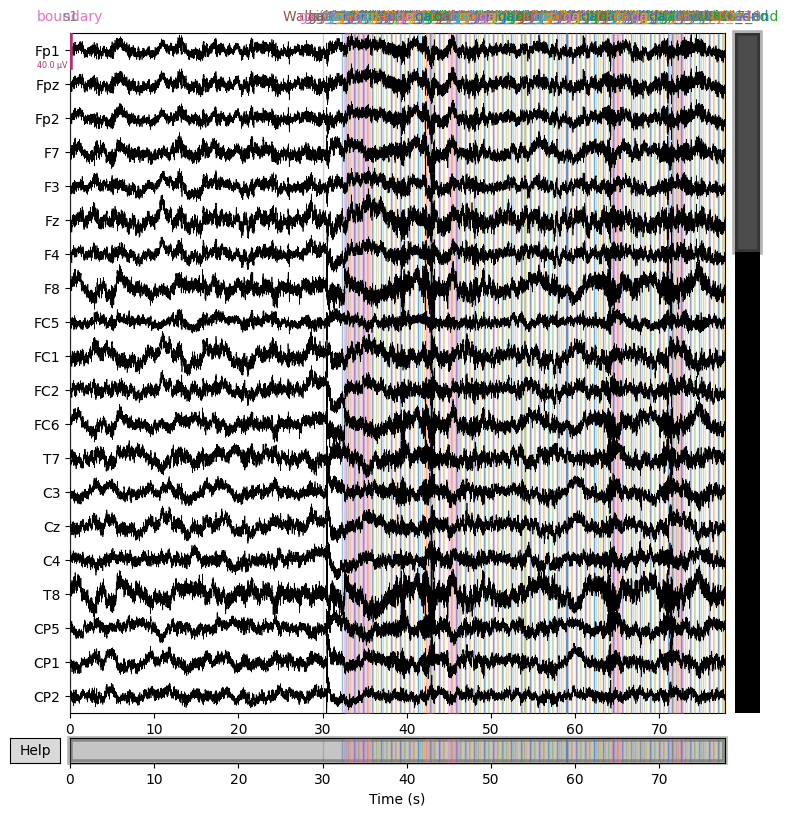

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 4.096 (s)


c:\Users\haiou\Documents\Cereneo\.venv\Lib\site-packages\mne\viz\utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


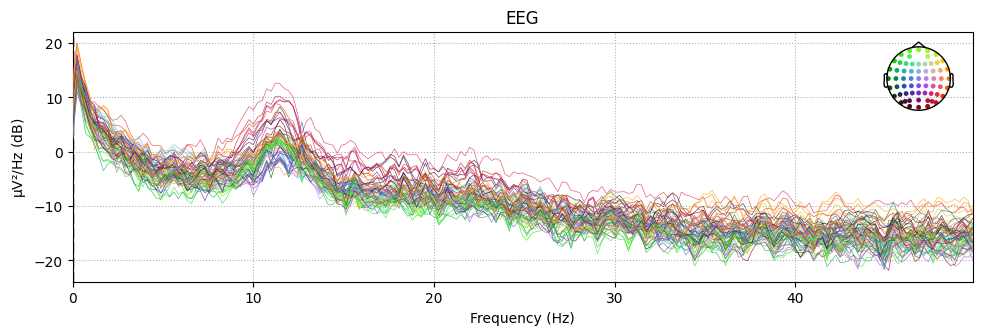

In [5]:

#EEG channel information
print(raw.info.get_channel_types)
#Plot of EEG data
raw.plot(start=0,duration=100)
plt.show()
#Plot of power density spectrum
raw.plot_psd(picks='eeg',fmax=50)
plt.show()

In [20]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
print(events_from_annot)
latencies = events_from_annot[:,0]
event_type = events_from_annot[:,2] 
dict_map = dict()
event_keys = list(event_dict.keys())
for i in range(len(event_keys)):
    dict_map[event_dict[event_keys[i]]] = event_keys[i]
event_type = [dict_map[x] for x in event_type]
gait_cycle_starts = [x for x in event_type if 'gait_cycle' in x and not 'end' in x]
gait_cycle_ends = [x for x in event_type if 'end' in x]
gait_cycles = [x for x in event_type if 'gait_cycle' in x]
print(gait_cycle_starts)
print(gait_cycle_ends)
print(gait_cycles)
cycles_kept = []

for i in range(len(gait_cycle_starts)):
    if gait_cycle_starts[i]+'_end' in gait_cycle_ends:
        cycles_kept.append(gait_cycle_starts[i])
        cycles_kept.append(gait_cycle_starts[i]+'_end')
print(cycles_kept)
cycles_removes = [x for x in gait_cycles if x not in cycles_kept]
print(cycles_removes)
cycles_kept_idx = [i for i in range(len(event_type)) if event_type[i] in cycles_kept]
print(cycles_kept_idx)
new_events = []
for j in np.arange(0,len(cycles_kept_idx),2):
    lower_bound = cycles_kept_idx[j] 
    upper_bound = cycles_kept_idx[j+1]+1
    new_events.append(events_from_annot[lower_bound:upper_bound])
new_events = np.vstack(new_events)
print(new_events)

In [62]:
translate_events(new_events,event_dict)

['gait_cycle4',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle4_end',
 'gait_cycle5',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle5_end',
 'gait_cycle6',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle6_end',
 'gait_cycle7',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle7_end',
 'gait_cycle8',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle8_end',
 'gait_cycle9',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle9_end',
 'gait_cycle10',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle10_end',
 'gait_cycle13',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle13_end',
 'gait_cycle17',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle17_end',
 'gait_cycle18',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle18_end',
 'gait_cycle19',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle19_end',
 'gait_cycle20',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle20_end',
 'gait_cycle21',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle21_end',
 'gait_cycle22',
 'LHS',
 'RTO',
 'RHS',
 'LTO',
 'gait_cycle22_end',
 'gait_cycle23',
 'LHS',
 'RTO',

In [64]:
filter_events(raw)

Used Annotations descriptions: ['LHS', 'LTO', 'RHS', 'RTO', 'Walk Onset', 'boundary', 'gait_cycle0', 'gait_cycle10', 'gait_cycle10_end', 'gait_cycle11', 'gait_cycle12_end', 'gait_cycle13', 'gait_cycle13_end', 'gait_cycle14', 'gait_cycle16_end', 'gait_cycle17', 'gait_cycle17_end', 'gait_cycle18', 'gait_cycle18_end', 'gait_cycle19', 'gait_cycle19_end', 'gait_cycle20', 'gait_cycle20_end', 'gait_cycle21', 'gait_cycle21_end', 'gait_cycle22', 'gait_cycle22_end', 'gait_cycle23', 'gait_cycle23_end', 'gait_cycle24', 'gait_cycle24_end', 'gait_cycle25', 'gait_cycle25_end', 'gait_cycle26', 'gait_cycle26_end', 'gait_cycle27', 'gait_cycle27_end', 'gait_cycle28', 'gait_cycle28_end', 'gait_cycle29', 'gait_cycle29_end', 'gait_cycle30', 'gait_cycle30_end', 'gait_cycle31', 'gait_cycle31_end', 'gait_cycle32', 'gait_cycle32_end', 'gait_cycle33', 'gait_cycle34_end', 'gait_cycle35', 'gait_cycle35_end', 'gait_cycle36', 'gait_cycle36_end', 'gait_cycle37', 'gait_cycle37_end', 'gait_cycle38', 'gait_cycle38_end',

array([[16848,     0,    61],
       [16848,     0,     1],
       [16928,     0,     4],
       [17093,     0,     3],
       [17163,     0,     2],
       [17398,     0,    77],
       [17398,     0,    78],
       [17398,     0,     1],
       [17468,     0,     4],
       [17633,     0,     3],
       [17708,     0,     2],
       [17948,     0,    79],
       [17948,     0,    80],
       [17948,     0,     1],
       [18023,     0,     4],
       [18193,     0,     3],
       [18263,     0,     2],
       [18498,     0,    81],
       [18498,     0,    82],
       [18498,     0,     1],
       [18573,     0,     4],
       [18738,     0,     3],
       [18818,     0,     2],
       [19058,     0,    83],
       [19058,     0,    84],
       [19058,     0,     1],
       [19143,     0,     4],
       [19303,     0,     3],
       [19368,     0,     2],
       [19598,     0,    85],
       [19598,     0,    86],
       [19598,     0,     1],
       [19683,     0,     4],
       [19

## ICA

In [44]:
ica_path = r'C:\Users\haiou\Documents\Cereneo\Data\Study\5_single-subject-EEG-analysis\sub-5\sub-5_Baseline_ICA_data.mat'
ica_data = scipy.io.loadmat(ica_path)
ica_data = ica_data['ICA']

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


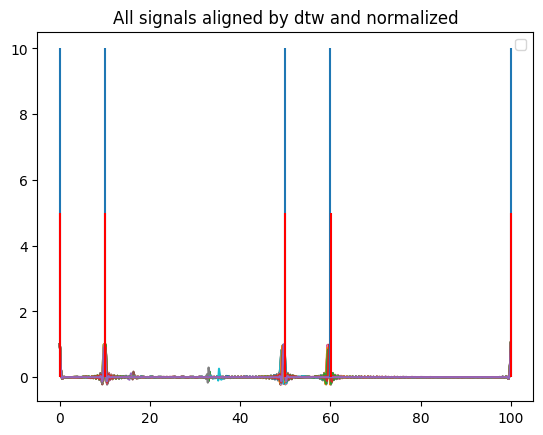

In [52]:
epoched_ica,templates,epoched_ica_resampled,reference_id  = epoch_set(ica_data,events_from_annot,event_dict,new_events)
epoched_ica_warped = time_warp_signal_3(epoched_ica_resampled,templates,reference_id,template)

# Annotate EEG

In [ ]:
# Get vicon file to annotate Left Heel Strikes (LHS) onto eeg
file_path = get_parameter_path(subject_id,condition)
raw_annotated = annotate_eeg(raw,file_path)
raw_annotated.plot(start=0,duration = 70)
plt.show()

In [ ]:
mne.export.export_raw(r"C:/Users/haiou/Documents/Cereneo/Data/5_single-subject-EEG-analysis/sub-5/raw_annotated_mne.set",raw_annotated)

# Epoch EEG

In [74]:
epochs,templates,epochs_resampled,reference_id,baseline = epoch_set(eeg_data,events_from_annot,event_dict,new_events)
print(reference_id)
print(len(epochs))

34
35


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


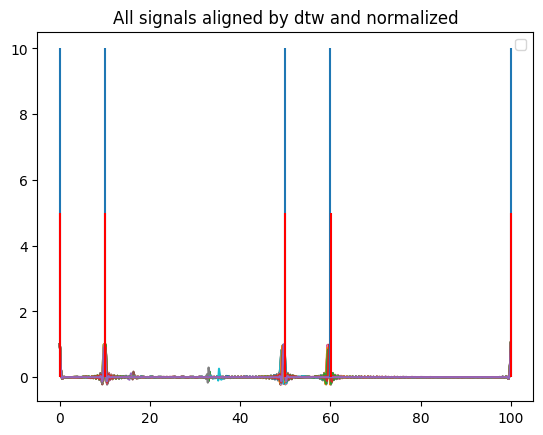

In [11]:
epoch_warped = time_warp_signal_3(epochs_resampled,templates,reference_id,template)

In [7]:
data = epoch_warped[:,61,:]
times = np.linspace(0,100,data.shape[-1])

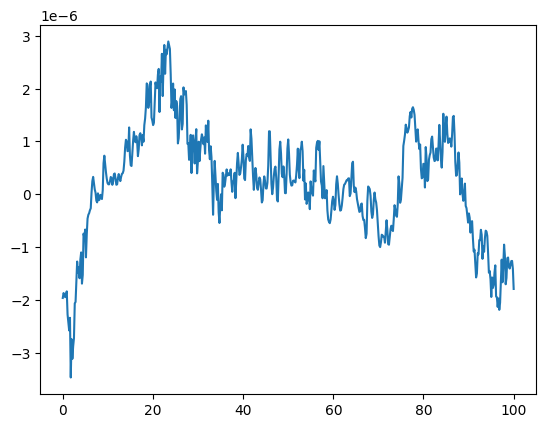

In [13]:
sns.lineplot(x=times,y=np.mean(data,axis=0))
plt.show()

## Dataframe

In [29]:
epoch_df = epoch_to_dataframe(epoch_warped,raw,subject_id,condition,ROI=['Pz'])

In [27]:
epoch_df

,values,times,condition,subjects,channels,cycle
0,-0.000007,0.000000,Baseline,5,Cz,0
1,-0.000005,0.177305,Baseline,5,Cz,0
2,-0.000007,0.354610,Baseline,5,Cz,0
3,-0.000008,0.531915,Baseline,5,Cz,0
4,-0.000007,0.709220,Baseline,5,Cz,0
...,...,...,...,...,...,...
19770,-0.000010,99.290780,Baseline,5,Cz,34
19771,-0.000009,99.468085,Baseline,5,Cz,34
19772,-0.000007,99.645390,Baseline,5,Cz,34
19773,-0.000005,99.822695,Baseline,5,Cz,34


<Axes: xlabel='times', ylabel='values'>

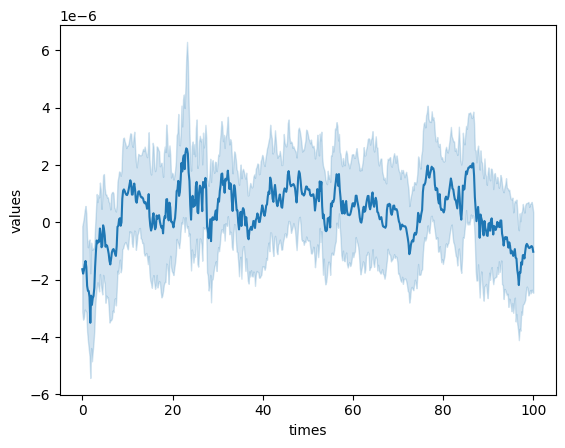

In [30]:
sns.lineplot(data=epoch_df,x='times',y='values')

## From annotation - no time warping!

In [ ]:
epochs = epoch_from_annotations(raw_annotated,ch_picks=get_ROI(raw_annotated))

In [ ]:
freqs = np.arange(2, 36)  # frequencies from 2-35Hz
#vmin, vmax = -0.5, 0.5  # set min and max ERDS values in plot
baseline = (-0.01, 0.01)  # baseline interval (in s)
#cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
tmin = -0.01
tmax = 1
kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test
tfr = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in epochs.event_id:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            #cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

# Align EEG

In [ ]:
# Get VICON data to segment the EEG into same-length epochs by upsamling each gait cycle to max_gait_cycle_length
file_path  = get_parameter_path(subject_id,condition)
epochs,epochs_resampled,epochs_ica_resampled = align_eeg(file_path,raw,[])

In [ ]:
template = np.zeros((101,))
template[[0,10,50,60,100]] = 1
epochs_warped = time_warp_signal_2(epochs_resampled,file_path,template=template)

In [ ]:
# Reconstruct the EEG by putting epochs one after the other
info = mne.create_info(raw.info['ch_names'],epochs_resampled[0].shape[1])
single_epoch = mne.io.RawArray(epochs_resampled[0],info)
eeg = reconstruct_eeg(raw,epochs_resampled)

In [ ]:
eeg.plot(duration=10)
plt.show()
eeg.plot_psd(fmax=50)
plt.show()

# Align motion

In [ ]:
align_motion(file_path,raw,epochs_resampled)

# Events

In [ ]:
epochs = get_epoch(eeg,preload=True)
events, event_ids = mne.events_from_annotations(eeg)
epochs.plot(picks=epochs.ch_names,events=events)
montage = mne.channels.make_standard_montage('standard_1005', head_size='auto')
epochs.set_montage(montage)
plt.show()

In [ ]:
epoch_marker = 'LHS'
epochs[epoch_marker].plot_psd(0,80)
plt.show()

# ERPs

In [ ]:
epochs[epoch_marker].average().plot_topo()
plt.show()

In [ ]:
erps = epochs[epoch_marker].average(picks=['CPz'],method='mean')
fig = plt.figure()
plt.plot(erps.times,erps.data[0])
axs = fig.axes[0]
events = ['LHS','RTO','RHS','LTO']
x = [0,0.10,0.5,0.6]
for i in range(len(x)):
    axs.axvline(x=x[i], color='black', linestyle='--', label=events[i])  # Customize color and linestyle as needed
    plt.text(x[i], 1e-6, events[i], rotation=90, verticalalignment='center')

plt.show()

fig.suptitle('test title', fontsize=12)
plt.xlabel('xlabel', fontsize=10)
plt.ylabel('ylabel', fontsize='medium')
axs.legend()
plt.show()

In [ ]:

fig = epochs[epoch_marker].average(picks=['CPz'],method='mean').plot(hline=[0,0.1,0.5,0.6])
# Assuming there's only one subplot, access the first (and likely only) axes
ax = fig.axes[0]

# Specify the time (in seconds) where you want to add the vertical line
# For example, to add a line at 0 seconds (typically event onset)
time_of_interest = 0.5  # Adjust this value as needed

# Add a vertical line at the specified time
#fig.axvline(x=time_of_interest,ymin=0,ymax=10, color='red', linestyle='--', label='Event onset')

# Optionally, if you want to add a legend or further customize the plot
ax.legend()

# Show the plot, if it doesn't automatically display
fig.show()

In [ ]:
erps = epochs['LHS'].average(picks=get_ROI(eeg,['F','C','P']))
times = [0,0.1,0.5,0.6]
erps.plot_joint(times=times)
plt.show()

In [ ]:
erps.plot(gfp=True, spatial_colors=True, ylim=dict(eeg=[-12, 12]))
plt.show()

### ERP image depending on side

In [ ]:
side_chs = [x for x in erps.info["ch_names"] if x[-1] != 'z']
left_ch = [x for x in side_chs if int(x[-1]) & 1]
right_ch = [x for x in side_chs if not int(x[-1]) & 1]
center_ch = [x for x in erps.info["ch_names"] if x not in side_chs]

In [ ]:
print(right_ch)
print(center_ch)

In [ ]:
erps.plot_image(picks=center_ch,show_names='all',clim=dict(eeg=[-5, 5]))
erps.plot_image(picks=left_ch,show_names='all',clim=dict(eeg=[-5, 5]))
erps.plot_image(picks=right_ch,show_names='all',clim=dict(eeg=[-5, 5]))
plt.show()

## ERDS

In [ ]:
epochs_erds = epochs.copy().load_data()
pick_chs = [ch for ch in epochs_erds.ch_names if ch[0] == 'C']
epochs_erds.pick_channels(pick_chs)

In [ ]:
epochs_erds['LHS'].average().plot()
plt.show()

In [ ]:
epochs['LHS'].plot_image()
plt.show()

In [ ]:
freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
tmin = 0 
tmax = 1
kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

In [ ]:
ch_names = epochs.ch_names
picked_chs = [x for x in ch_names if x[0] == 'C']
epochs.load_data()
epochs.pick(picked_chs)
baseline = (-0.1,0)
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                            return_itc=False, average=False, decim=2,picks=epochs.ch_names)



In [ ]:
tfr.data

In [ ]:
tfr.crop(tmin-0.1, tmax).apply_baseline(baseline, mode="percent")
event_ids = epochs.event_id
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [ ]:
     
channels = tfr.ch_names
trials = list(tfr.event_id.keys())
freq_mask = (tfr.freqs >= 8) & (tfr.freqs <= 12)
fig,axs = plt.subplots(1,len(picked_chs))
        
for k,ch in enumerate(channels):
    for trial in trials:
        current_tfr = tfr.copy().pick([ch])
        selection = current_tfr[trial].data[:,:,freq_mask,:]
        avg = np.nanmean(np.mean(selection,axis=2),axis=0)
        axs[k].plot(tfr.times,avg[0],color='red')
    axs[k].grid(True)
    #axs[k].set_ylim([0, 1])
    axs[k].set_xlim([0, 1])
    axs[k].axvline(x = baseline[1], color = 'black',linestyle="--", label = 'trial onset')
    axs[k].axhline(y = 0., color = 'black',linestyle="--")
    axs[k].legend()
    axs[k].set_title(ch)
fig.tight_layout()
fig.set_figwidth(len(picked_chs)*10)
#fig.suptitle(cond, fontsize=10)
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
plt.show()


In [ ]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {"_": 0, "delta": 3, "theta": 7, "alpha": 13, "beta": 35, "gamma": 140}
df["band"] = pd.cut(
    df["freq"], list(freq_bounds.values()), labels=list(freq_bounds)[1:]
)

# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ["delta", "theta", "alpha", "beta"]
df = df[df.band.isin(freq_bands_of_interest)]
df["band"] = df["band"].cat.remove_unused_categories()

# Order channels for plotting:
df["channel"] = df["channel"].cat.reorder_categories(("C3", "Cz", "C4"), ordered=True)

g = sns.FacetGrid(df, row="band", col="channel", margin_titles=True)
g.map(sns.lineplot, "time", "value", "condition", n_boot=10)
axline_kw = dict(color="black", linestyle="dashed", linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(None, 1.5))
g.set_axis_labels("Time (s)", "ERDS")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc="lower center")
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

## TFR time warping

In [ ]:
new_set = time_warp_signal(tfr['LHS'].data,file_path,reference_id=21)

In [ ]:
fig,axs = plt.subplots(new_set.shape[1],4,figsize=(10,10))
df = pd.read(file_path)
for i in range(new_set.shape[1]):
    
    freq = 33
    axs[i,1].plot(new_set[100,i,freq,:])
    axs[i,0].plot(tfr.data[100,i,freq,:])
    axs[i,3].plot(new_set[150,i,freq,:])
    axs[i,2].plot(tfr.data[150,i,freq,:])
plt.show()

In [ ]:
idxs = (new_set == 0)

In [ ]:
tfr.data[idxs]

In [ ]:
new_tfr = tfr.copy()
new_tfr.data = new_set

In [ ]:
new_tfr.data[idxs] = tfr.data[idxs]

In [ ]:
np.argwhere(np.isnan(new_tfr.data))

In [ ]:
baseline = (None,None)
new_tfr.crop(tmin-0.1, tmax).apply_baseline(baseline, mode="percent")
event_ids = epochs.event_id
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = new_tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [ ]:
new_tfr.ch_names

# Global TFR - EEG

In [ ]:
# gait TFR
freqs = np.arange(1, 80)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
tmin = 0 
tmax = 1
kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test
pick_chs = get_ROI(raw,['C'])
selected_data = raw.get_data(picks=pick_chs)
selected_data = selected_data[np.newaxis,...]
tfr = mne.time_frequency.tfr_array_multitaper(selected_data, sfreq = 500, freqs=freqs, n_cycles=freqs, use_fft=True,
                            decim=1,output='power')


In [ ]:
# baseline TFR
condition_baseline = 'standing'
recording_path_baseline = get_recording_path(subject_id,condition)
raw_baseline = mne.io.read_raw_eeglab(recording_path_baseline)
selected_data_baseline = raw_baseline.get_data(picks=pick_chs)
selected_data_baseline = selected_data_baseline[np.newaxis,...]
tfr_baseline = mne.time_frequency.tfr_array_multitaper(selected_data_baseline, sfreq = 500, freqs=freqs, n_cycles=freqs, use_fft=True,
                            decim=1,output='power')

In [ ]:
file_path = get_parameter_path(subject_id,condition)
tfr_copy = np.squeeze(tfr.copy())
epoched_tfr,min_length,min_id = get_epoched_tfr(raw,file_path,tfr_copy,resampling=True)

## Warping

In [ ]:
template = np.zeros((101,))
template[[0,10,50,60,100]] = 1
warped_tfr = time_warp_signal_2(epoched_tfr,file_path,template=template)

In [ ]:
warped_tfr.shape

## tfr ERDS

In [ ]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
latencies = events_from_annot[:,0]
event_type = events_from_annot[:,2] 
dict_map = dict()
event_keys = list(event_dict.keys())
for i in range(len(event_keys)):
    dict_map[event_dict[event_keys[i]]] = event_keys[i]
event_type = [dict_map[x] for x in event_type]
LHS_idxs = [i for i,event in enumerate(event_type) if ('LHS' in event) and not ('_nxt' in event)]
idxs = [i for i,event in enumerate(event_type) if event != 's1']
event_type = [event_type[i] for i in idxs]
latencies = [latencies[i] for i in idxs]

In [ ]:
new_latencies = []
for j in range(warped_tfr.shape[0]):
    new_latencies = new_latencies + [j*warped_tfr.shape[-1],j*warped_tfr.shape[-1]+int(0.1*warped_tfr.shape[-1]),
                                     j*warped_tfr.shape[-1]+int(0.5*warped_tfr.shape[-1]),j*warped_tfr.shape[-1]+int(0.6*warped_tfr.shape[-1])
                                     ,j*warped_tfr.shape[-1]+warped_tfr.shape[-1]]

In [ ]:
dict_map = dict()
for i in range(len(event_keys)):
    if event_keys[i] in event_type:
        dict_map[event_dict[event_keys[i]]] = event_keys[i]
print(dict_map)

In [ ]:
event_type = [x for x in event_type if ('LHS' in x) and not ('_nxt' in x)]
new_latencies = np.arange(208)
new_event_dict = {key: event_dict[key] for key in event_keys if ('LHS' in key) and not ('_nxt' in key)}
print(new_event_dict)

In [ ]:
data = warped_tfr
new_events = np.zeros((len(new_latencies),3))
new_events[:,0] = new_latencies
new_events[:,2] = [event_dict[x] for x in event_type]
info = mne.create_info(pick_chs,data.shape[-1],ch_types='eeg')
times = np.linspace(0,1,data.shape[-1])
erds_tfr = mne.time_frequency.EpochsTFR(info,data,times, freqs,events=new_events,event_id=new_event_dict)

In [ ]:
vmin, vmax = -0.2, 0.2  # set min and max ERDS values in plot
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
tmin = 0 
tmax = 1
erds_tfr_baselined = tfr_baselining(tfr_baseline,erds_tfr)
evoked = erds_tfr_baselined['LHS:Unmatch']

In [ ]:
events_to_plot = ['LHS','RTO','RHS','LTO']
events_timestamps = [0,0.1,0.5,0.6]
event_ids = erds_tfr_baselined.event_id
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = erds_tfr_baselined[event]
    fig, axes = plt.subplots(
        5, 6, figsize=(40, 30)
    )
    for idx, ch in enumerate(evoked.ch_names):  # for each channel
        '''
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, idx], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, idx], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.1].any(axis=-1)
        '''
        # plot TFR (ERDS map with masking)
        x = idx//axes.shape[1]
        y = idx%axes.shape[1]
        
        tfr_ev.average().plot(
                    [ch],
                    cmap="RdBu",
                    #cnorm=cnorm,
                    vmin=-0.2,
                    vmax=0.2,
                    axes=axes[x,y],
                    colorbar=True,
                    show=False,
                    #hline=[0,0.1,0.5,0.6]
                    #mask=mask,
                    #mask_style="mask",
                )

        axes[x,y].set_title(erds_tfr_baselined.ch_names[idx], fontsize=10)
        for k in range(len(events_to_plot)):
            axes[x,y].axvline(events_timestamps[k], linewidth=1, color="black", linestyle=":")  # event
            axes[x,y].text(events_timestamps[k], 0.8*freqs[-1], events_to_plot[k], rotation=90, verticalalignment='center',fontsize='xx-large')
    #fig.colorbar(axes[0].images[-1], cax=ax[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [ ]:
fig,axs = plt.subplots(1,2)
chs = ['Cz','C3']

for idx,ch in enumerate(chs):
    print(idx)
    tfr_ev.average().plot(
                [ch],
                cmap="RdBu",
                #cnorm=cnorm,
                vmin=-0.2,
                vmax=0.2,
                axes=axs[idx],
                colorbar=True,
                show=False,
                #hline=[0,0.1,0.5,0.6]
                #mask=mask,
                #mask_style="mask",
            )
    
plt.show()

In [ ]:
plt.figure()
erds_tfr_baselined['1'].average().plot(vmin=-0.5,vmax=0.5)
plt.show()

### TFR using t=0s baseline

In [ ]:
freqs = np.arange(2, 36)  # frequencies from 2-35Hz
vmin, vmax = -0.5, 0.5  # set min and max ERDS values in plot
baseline = (0, 0.005)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test
event_ids = erds_tfr.event_id

In [ ]:
erds_tfr.times

In [ ]:
erds_to_plot = erds_tfr.copy().crop(tmin, tmax)#.apply_baseline(baseline, mode="percent")

In [ ]:
plt.figure()
erds_to_plot['LHS:Match'].average().plot(cmap="RdBu")
plt.show()

In [ ]:
erds_tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
event_ids = erds_tfr.event_id
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = erds_tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        '''
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)
        '''
        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            #mask=mask,
            #mask_style="mask",
        )

        ax.set_title(erds_tfr.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

# Events for eeglab

In [ ]:
file_path

In [ ]:
events = events_for_eeglab(raw,file_path,subject_id,condition)

In [ ]:
np.mean(np.diff(events['latency']))

# Global TFR - ICA

In [56]:
ica_data[np.newaxis,...].shape

(1, 11, 38900)

In [57]:
# gait TFR
freqs = np.arange(1, 80)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
tmin = 0 
tmax = 1
kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

tfr = mne.time_frequency.tfr_array_multitaper(ica_data[np.newaxis,...], sfreq = 500, freqs=freqs, n_cycles=freqs, use_fft=True,
                            decim=1,output='power')


In [94]:
tfr_ica_epoched,templates,tfr_ica_epoched_resampled,reference_id,baseline = epoch_set(tfr[0],events_from_annot,event_dict,new_events)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


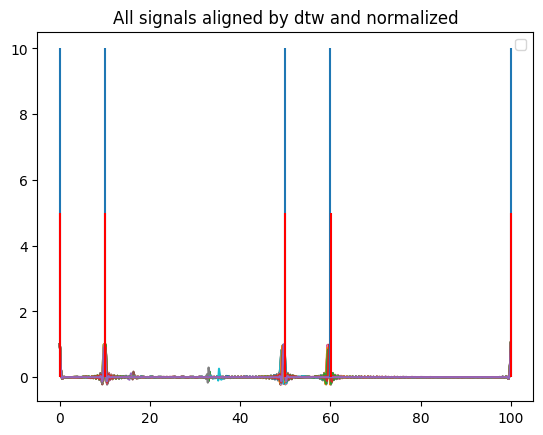

In [95]:
tfr_ica_warped = time_warp_signal_3(tfr_ica_epoched_resampled,templates,reference_id,template)

In [88]:
ica_data.shape

(11, 38900)

## Baseline

In [97]:
tfr_baselined = tfr_baselining(baseline,tfr_ica_warped)

C:\Users\haiou\AppData\Local\Temp\ipykernel_32208\1360361895.py:279: DeprecationWarning: Assigning the 'data' attribute is an inherently unsafe operation and will be removed in the future.
  baselined_tfr.data = (erds_tfr-mean_reshaped)/mean_reshaped


In [98]:
tfr_baselined.shape

(35, 11, 79, 565)

# Playground

## TFR warping trial

In [ ]:
# Here we assume that signal first dim = gait cycles and last dim = time points
target_signal = epoched_tfr
reference_id = 1

length_target_signal = target_signal.shape[-1]
df = pd.read_csv(file_path) 

df_only_float_values = df.drop(
    columns=['cycle_number', 'start_frame', 'end_frame', 'Foot_Off_Contra', 'Foot_Strike_Contra', 'Foot_Off'])
df_only_float_values = df_only_float_values.astype(float)

df_only_float_values['Non-NaN Count'] = df_only_float_values.apply(lambda row: row.notna().sum(), axis=1)
min_length = np.min(df_only_float_values.iloc[:]['Non-NaN Count'].values)
max_length = np.max(df_only_float_values.iloc[:]['Non-NaN Count'].values)
subset_signal = df_only_float_values[(df_only_float_values['Non-NaN Count'] < 2 * min_length)]
subset_signal = subset_signal.reset_index(drop=True)

subset_signal_only_float_values = subset_signal.drop(columns=['Non-NaN Count'])

In [ ]:
df.head()

In [ ]:
print(min_length)
print(max_length)

In [ ]:
if reference_id is not None:
    reference_signal = subset_signal_only_float_values.iloc[reference_id]
    reference_signal = reference_signal[~np.isnan(reference_signal)]
    #reference_signal = upsample(reference_signal,100,500)
    reference_signal = resample(reference_signal, length_target_signal)
else:
    median_per_column = subset_signal_only_float_values.median(axis=0)
    median_per_column = median_per_column[~np.isnan(median_per_column)]
    reference_signal = resample(median_per_column, min_length)



In [ ]:
reference_signal.shape

In [ ]:
row = df.iloc[0]
markers_signal = np.zeros((int(row['end_frame']-row['start_frame']),))
markers_idxs = row[1:6].values.astype(np.int32)
markers_idxs[0] = 0
markers_idxs[1] = len(markers_signal)-1
markers_signal[markers_idxs] = 1
markers_signal = resample(markers_signal,)
plt.plot(markers_signal)
plt.show()


In [ ]:
b, a = butter(2, 6, fs=100, btype='low')
reference_signal_filt = filtfilt(b, a, reference_signal)
reference_signal_filt = reference_signal_filt.astype(float)
fig,axs = plt.subplots(2,1)
all_signals_aligned_by_dtw = pd.DataFrame()
min_distance_dtw = float('inf')
max_distance_dtw = 0

new_set = np.zeros(target_signal.shape)

for i in range(target_signal.shape[0]):

    gait_cycle_1 = subset_signal_only_float_values.iloc[i][:].values
    nan_mask = np.isnan(gait_cycle_1)
    gait_cycle_1 = gait_cycle_1[~nan_mask]
    row = df.iloc[0]
    markers_signal = np.zeros((int(row['end_frame']-row['start_frame']),))
    markers_idxs = row[1:6].values.astype(np.int32)
    markers_idxs[0] = 0
    markers_idxs[1] = len(markers_signal)-1
    markers_signal[markers_idxs] = 1
    markers_signal = resample(markers_signal,length_target_signal)
    gait_cycle_1 = resample(gait_cycle_1,length_target_signal)
    warped_signal = markers_signal
    y = filtfilt(b, a, warped_signal)
    float_array_gait_cycle = y.astype(float)

    alignment2 = dtw(float_array_gait_cycle, reference_signal_filt, keep_internals=True,
                        step_pattern=rabinerJuangStepPattern(3, "c"))

    if alignment2.distance < min_distance_dtw:
        min_distance_dtw = alignment2.distance

    if alignment2.distance > max_distance_dtw:
        max_distance_dtw = alignment2.distance

    id_reference2 = alignment2.index2
    id_query2 = alignment2.index1
    cs2 = CubicSpline(id_reference2, warped_signal[id_query2])
    ms2 = CubicSpline(id_reference2, markers_signal[id_query2])

    xs = np.arange(length_target_signal)
    xs2 = np.arange(0,len(id_query2))
    signal_aligned_by_dtw = cs2(xs)
    signal_aligned_by_dtw2 = cs2(xs2)
    markers_aligned = ms2(xs)
    
    sub_target_signal = target_signal[i]
    ts2 = CubicSpline(id_reference2, sub_target_signal[...,id_query2],axis=-1)
    target_signal_aligned = ts2(xs)
    new_set[i,:] = target_signal_aligned
    signal_aligned_by_dtw_df = pd.DataFrame(signal_aligned_by_dtw)
    signal_aligned_by_dtw_df = signal_aligned_by_dtw_df.transpose()
    all_signals_aligned_by_dtw = pd.concat([all_signals_aligned_by_dtw, signal_aligned_by_dtw_df], axis = 0)
    all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.reset_index(drop=True)
    all_signals_aligned_by_dtw = all_signals_aligned_by_dtw.astype(float)

    axs[0].plot(np.linspace(0, 100, len(xs)),signal_aligned_by_dtw)
    axs[1].plot(np.linspace(0, 100, len(xs)),markers_aligned)

plt.title('All signals aligned by dtw and normalized')
plt.legend()
plt.show()

In [ ]:
new_set.shape

## EVENTS

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper

In [ ]:
fnames = eegbci.load_data(subject=1, runs=(6, 10, 14))
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])

raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
# rename descriptions to be more easily interpretable
raw.annotations.rename(dict(T1="hands", T2="feet"))

In [ ]:
fnames = eegbci.load_data(subject=1, runs=(6, 10, 14))
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])

raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
# rename descriptions to be more easily interpretable
raw.annotations.rename(dict(T1="hands", T2="feet"))

In [ ]:
raw.plot()

In [ ]:
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks

epochs = mne.Epochs(
    raw,
    event_id=["hands", "feet"],
    tmin=tmin - 0.5,
    tmax=tmax + 0.5,
    picks=("C3", "Cz", "C4"),
    baseline=None,
    preload=True,
)

## Custom time-warping V1

In [ ]:
raw.plot(duration=10)
plt.show()

In [ ]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
eeg_warped = []
event_keys = list(event_dict.keys())
LHS_key = [key for key in event_keys if ('LHS' in key and not '_nxt' in key)]
LHS_marker = [event_dict[x] for x in LHS_key]
LHS_events = [events_from_annot[events_from_annot[:,2]==x] for x in LHS_marker]
LHS_array = np.vstack(LHS_events)
sorted_idx = np.argsort(LHS_array[:,0],axis=0)
LHS_array = LHS_array[sorted_idx,:]

In [ ]:
latencies = events_from_annot[:,0]
event_type = events_from_annot[:,2] 
dict_map = dict()
for i in range(len(event_keys)):
    dict_map[event_dict[event_keys[i]]] = event_keys[i]
event_type = [dict_map[x] for x in event_type]
LHS_idxs = [i for i,event in enumerate(event_type) if ('LHS' in event) and not ('_nxt' in event)]

In [ ]:
eeg_data = raw.get_data()
ratios = [0,0.1,0.5,0.6,1]
low_bound = latencies[LHS_idxs[0]]
max_sample_length = 0
for k in range(len(LHS_idxs)):
    idx = LHS_idxs[k]
    marker_idxs = [latencies[idx],latencies[idx+1],latencies[idx+2],latencies[idx+3],latencies[idx+4]]
    eeg_segment = eeg_data[:,marker_idxs[0]:marker_idxs[-1]]
    if eeg_segment.shape[1]>max_sample_length:
        max_sample_length = eeg_segment.shape[1]
new_events_latencies = np.zeros((5*len(LHS_idxs),))
new_event_types = []
resampled_eeg = np.zeros(eeg_data.shape)
resampled_eeg[:,0:(latencies[LHS_idxs[0]]-1)] = eeg_data[:,0:(latencies[LHS_idxs[0]]-1)]
for i in range(len(LHS_idxs)):
    idx = LHS_idxs[i]
    marker_idxs = [latencies[idx],latencies[idx+1],latencies[idx+2],latencies[idx+3],latencies[idx+4]]
    eeg_segment = eeg_data[:,marker_idxs[0]:marker_idxs[-1]]
    n_samples = eeg_segment.shape[1]
    current_epoch = np.zeros(eeg_segment.shape)
    new_latencies = np.zeros((len(marker_idxs),))
    for j in range(len(marker_idxs)-1):
        low = marker_idxs[j] - marker_idxs[0]
        high = marker_idxs[j+1] - marker_idxs[0]
        new_low = math.floor(ratios[j]*n_samples)
        new_high = math.floor(ratios[j+1]*n_samples)
        new_latencies[j] = new_low + low_bound
        new_latencies[j+1] = new_high + low_bound
        current_epoch[:,new_low:new_high] = resample(eeg_segment[:,low:high],new_high-new_low,axis=-1)
    new_events_latencies[i*5:(i+1)*5] = new_latencies
    new_event_types = new_event_types + [event_type[idx],event_type[idx+1],event_type[idx+2],event_type[idx+3],event_type[idx+4]]
    resampled_eeg[:,low_bound:low_bound+n_samples] = current_epoch
    low_bound = n_samples + low_bound

In [ ]:
info = mne.create_info(raw.info['ch_names'],raw.info['sfreq'],ch_types='eeg')
reconstructed_eeg = mne.io.RawArray(resampled_eeg,info)
new_events = np.zeros((len(new_events_latencies),3))
new_events[:,0] = new_events_latencies
new_events[:,2] = [event_dict[x] for x in new_event_types]
annots = mne.annotations_from_events(new_events, raw.info['sfreq'], event_desc=dict_map)
reconstructed_eeg = reconstructed_eeg.copy().set_annotations(annots);


In [ ]:
reconstructed_eeg.plot(start=0,duration=10)
raw.plot(duration=10)
plt.show()

In [ ]:
reconstructed_eeg.plot_psd(picks='eeg',fmax=50)

## Custom time-warping V2

In [ ]:
events_from_annot, event_dict = mne.events_from_annotations(raw)
eeg_warped = []
event_keys = list(event_dict.keys())
LHS_key = [key for key in event_keys if ('LHS' in key and not '_nxt' in key)]
LHS_marker = [event_dict[x] for x in LHS_key]
LHS_events = [events_from_annot[events_from_annot[:,2]==x] for x in LHS_marker]
LHS_array = np.vstack(LHS_events)
sorted_idx = np.argsort(LHS_array[:,0],axis=0)
LHS_array = LHS_array[sorted_idx,:]

In [ ]:
latencies = events_from_annot[:,0]
event_type = events_from_annot[:,2] 
dict_map = dict()
for i in range(len(event_keys)):
    dict_map[event_dict[event_keys[i]]] = event_keys[i]
event_type = [dict_map[x] for x in event_type]
LHS_idxs = [i for i,event in enumerate(event_type) if ('LHS' in event) and not ('_nxt' in event)]

In [ ]:
eeg_data = raw.get_data()
n_resample=600
ratios = [0,0.1,0.5,0.6,1]
low_bound = 0
max_sample_length = 0
for k in range(len(LHS_idxs)):
    idx = LHS_idxs[k]
    marker_idxs = [latencies[idx],latencies[idx+1],latencies[idx+2],latencies[idx+3],latencies[idx+4]]
    eeg_segment = eeg_data[:,marker_idxs[0]:marker_idxs[-1]]
    if eeg_segment.shape[1]>max_sample_length:
        max_sample_length = eeg_segment.shape[1]
new_events_latencies = np.zeros((5*len(LHS_idxs),))
new_event_types = []
resampled_eeg = np.zeros((eeg_data.shape[0],len(LHS_idxs)*n_resample))
#resampled_eeg[:,0:(latencies[LHS_idxs[0]]-1)] = eeg_data[:,0:(latencies[LHS_idxs[0]]-1)]
for i in range(len(LHS_idxs)):
    idx = LHS_idxs[i]
    marker_idxs = [latencies[idx],latencies[idx+1],latencies[idx+2],latencies[idx+3],latencies[idx+4]]
    eeg_segment = eeg_data[:,marker_idxs[0]:marker_idxs[-1]]
    eeg_segment_resampled=resample(eeg_segment,n_resample,axis=-1)
    n_samples = eeg_segment_resampled.shape[1]
    current_epoch = np.zeros(eeg_segment_resampled.shape)
    new_latencies = np.zeros((len(marker_idxs),))
    for j in range(len(marker_idxs)-1):
        low = int((marker_idxs[j] - marker_idxs[0])*n_resample/eeg_segment.shape[1])
        high = int((marker_idxs[j+1] - marker_idxs[0])*n_resample/eeg_segment.shape[1])
        new_low = math.floor(ratios[j]*n_samples)
        new_high = math.floor(ratios[j+1]*n_samples)
        new_latencies[j] = new_low + low_bound
        new_latencies[j+1] = new_high + low_bound
        current_epoch[:,new_low:new_high] = resample(eeg_segment_resampled[:,low:high],new_high-new_low,axis=-1)
    new_events_latencies[i*5:(i+1)*5] = new_latencies
    new_event_types = new_event_types + [event_type[idx],event_type[idx+1],event_type[idx+2],event_type[idx+3],event_type[idx+4]]
    resampled_eeg[:,low_bound:low_bound+n_samples] = current_epoch
    low_bound = n_samples + low_bound

In [ ]:
print(event_dict)

In [ ]:
info = mne.create_info(raw.info['ch_names'],n_resample,ch_types='eeg')
reconstructed_eeg = mne.io.RawArray(resampled_eeg,info)
new_events = np.zeros((len(new_events_latencies),3))
new_events[:,0] = new_events_latencies
new_events[:,2] = [event_dict[x] for x in new_event_types]
annots = mne.annotations_from_events(new_events, n_resample, event_desc=dict_map)
reconstructed_eeg = reconstructed_eeg.copy().set_annotations(annots);

In [ ]:
reconstructed_eeg.plot()
reconstructed_eeg.plot_psd(picks='eeg',fmax=50)
plt.show()